In [1]:
# import das bibliotecas
import psycopg2
import os

import numpy as np
import pandas as pd
import pandas.io.sql as sqlio

import random
import string

import shutil
import tempfile
import weakref

import timer3

import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.conversion.dfg import converter as dfg_mining
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.statistics.traces.log import case_statistics
from pm4py.statistics.traces.log import case_arrival

In [2]:
db_host = os.getenv('POSTGRES_HOST')
db_port = os.getenv('POSTGRES_PORT')
db_name = os.getenv('POSTGRES_DB')
db_user = os.getenv('POSTGRES_USER')
db_pass = os.getenv('POSTGRES_PASSWORD')

In [4]:
# Mapa chave=valor - ramo de justica/sufixo_tabela_fato
ramos_justica = {'Eleitoral': 'jele', 'Estadual': 'jest', 'Federal': 'jfed', 'Militar': 'jmil', 'Trabalho': 'jtra'}

In [5]:
class ModeloEstatisticas:

    def __init__(self, qtde_casos, caso_dur_min, caso_dur_max, caso_dur_media, \
                 taxa_chegada_casos, taxa_dispersao_casos):
        self.qtde_casos = qtde_casos
        self.caso_dur_min = caso_dur_min
        self.caso_dur_max = caso_dur_max
        self.caso_dur_media = caso_dur_media
        self.taxa_chegada_casos = taxa_chegada_casos
        self.taxa_dispersao_casos = taxa_dispersao_casos

In [6]:
# Cache para logs de evento
eventLogCache = {}

# Remove um log de eventos da cache pela chave
def clear_eventlog_cache(cacheKey):
    eventLog = eventLogCache.get(cacheKey)

    if eventLog is not None :
        eventLogCache[cacheKey] = None

In [13]:
# gera um log de eventos de acordo com os parametros informados.
def gerar_log_eventos(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, dtinicio, dtfim, 
                      baixado = None, sensibility = '60'):
    
    eventLog = None

    cacheKey = "{0}-{1}-{2}-{3}-{4}-{5}-{6}-{7}-{8}-{9}".format(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, dtinicio, dtfim, baixado)
    
    cachedEventLog = eventLogCache.get(cacheKey)
    if cachedEventLog is not None :
        eventLog = cachedEventLog

    else :
        conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
        
        sufixo_ramo = ramos_justica.get(ramo_justica, 'default')
        
        tabela_fato = "inovacnj.fat_movimento_" + sufixo_ramo
        
        qry = "SELECT "
        qry+= "  fat.npu as npu, "
        qry+= "  CASE "
        qry+= "  WHEN f.descricao IS NULL THEN fat.mov_cod ||  ' - ' || mov.descricao "
        qry+= "  ELSE f.descricao || ': ' || fat.mov_cod ||  ' - ' || mov.descricao "
        qry+= "  END AS atividade, "
        qry+= "  fat.mov_dtmov as mov_dtmov "
        qry+= "FROM " + tabela_fato + " fat "
        qry+= "INNER JOIN inovacnj.acervo_processo_" + sufixo_ramo + " ap ON ap.npu = fat.npu "
        qry+= "INNER JOIN inovacnj.orgao_julgador oj ON oj.cod = fat.oj_cod::integer "
        qry+= "INNER JOIN inovacnj.movimentocnj mov ON mov.cod = fat.mov_cod "
        qry+= "INNER JOIN inovacnj.natureza_classe nc ON nc.cod_classe = fat.codclasse "
        qry+= "INNER JOIN inovacnj.natureza nat ON nat.cod = nc.cod_natureza "
        qry+= "LEFT JOIN inovacnj.fase_movimento fm ON fm.cod_movimento = fat.mov_cod "
        qry+= "LEFT JOIN inovacnj.fase f ON f.cod = fm.cod_fase "
        qry+= "WHERE (1=1) "
        
        if baixado is not None :
            qry+= "AND ap.baixado = '" + baixado + "' "
        if codtribunal is not None :
            qry+= "AND fat.codtribunal = '" + codtribunal + "' "
        if atuacao is not None :
            qry+= "AND oj.atuacao_vara = '" + atuacao + "' "
        if codorgaoj is not None :
            qry+= "AND fat.oj_cod = '" + codorgaoj + "' "
        if grau is not None :
            qry+= "AND fat.grau = '" + grau + "' "
        if codnatureza is not None :
            qry+= "AND nat.cod = " + str(codnatureza) + " "
        if codclasse is not None :
            qry+= "AND fat.codclasse = " + str(codclasse) + " "
            
        if dtinicio is not None and dtfim is not None:
            qry+= "AND fat.mov_dtmov BETWEEN to_timestamp('" + dtinicio + "', 'yyyy-MM-dd') AND to_timestamp('" + dtfim + "', 'yyyy-MM-dd') "
            
        qry+= "ORDER BY fat.npu, fat.mov_dtmov ASC "
        
        print(qry)
        
        df_logeventos_pd = pd.read_sql_query(qry, conn)
        
        if df_logeventos_pd.empty == False :
            df_event_log = pm4py.format_dataframe(df_logeventos_pd, case_id='npu', activity_key='atividade', timestamp_key='mov_dtmov')
            eventLog = pm4py.convert_to_event_log(df_event_log)

            eventLogCache[cacheKey] = eventLog
            timer3.apply_after(1000 * 60 * 10, clear_eventlog_cache, args=([cacheKey]), priority=0)

    if eventLog is not None :
        if sensibility is not None :
            eventLog = pm4py.filter_variants_percentage(eventLog, percentage=float(sensibility) / 100)

    return eventLog

In [9]:
def gerar_dfg_model_from_log_eventos(eventLog):
    if eventLog != None :
        #Create dfg model from log
        return dfg_discovery.apply(eventLog)
    else :
        return None

In [10]:
def gerar_view_dfg_model(eventLog, dfg, metric_type = 'FREQUENCY', image_format = 'png'):
    gviz = None
    
    if metric_type == 'PERFORMANCE' :
        parameters = {dfg_visualization.Variants.PERFORMANCE.value.Parameters.FORMAT: image_format}
        # Visualise
        gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.PERFORMANCE, parameters=parameters)
    elif metric_type == 'FREQUENCY' :
        parameters = {dfg_visualization.Variants.FREQUENCY.value.Parameters.FORMAT: image_format}
        # Visualise
        gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.FREQUENCY, parameters=parameters)
    else :
        print("Invalid metric_type: " + metric_type)

    return gviz

In [11]:
# Gera a visualização do modelo com base nos parametros
def gerar_view_dfg_model_from_params(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, 
                                     dtinicio, dtfim, baixado = None, sensibility = '60', metric_type = 'FREQUENCY', image_format = 'png'):
    
    gviz = None
    
    eventLog = gerar_log_eventos(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, dtinicio, dtfim, baixado, sensibility)
    
    if eventLog is not None :
        dfg = gerar_dfg_model_from_log_eventos(eventLog)
        gviz = gerar_view_dfg_model(eventLog, dfg, metric_type, image_format)
    
    return gviz

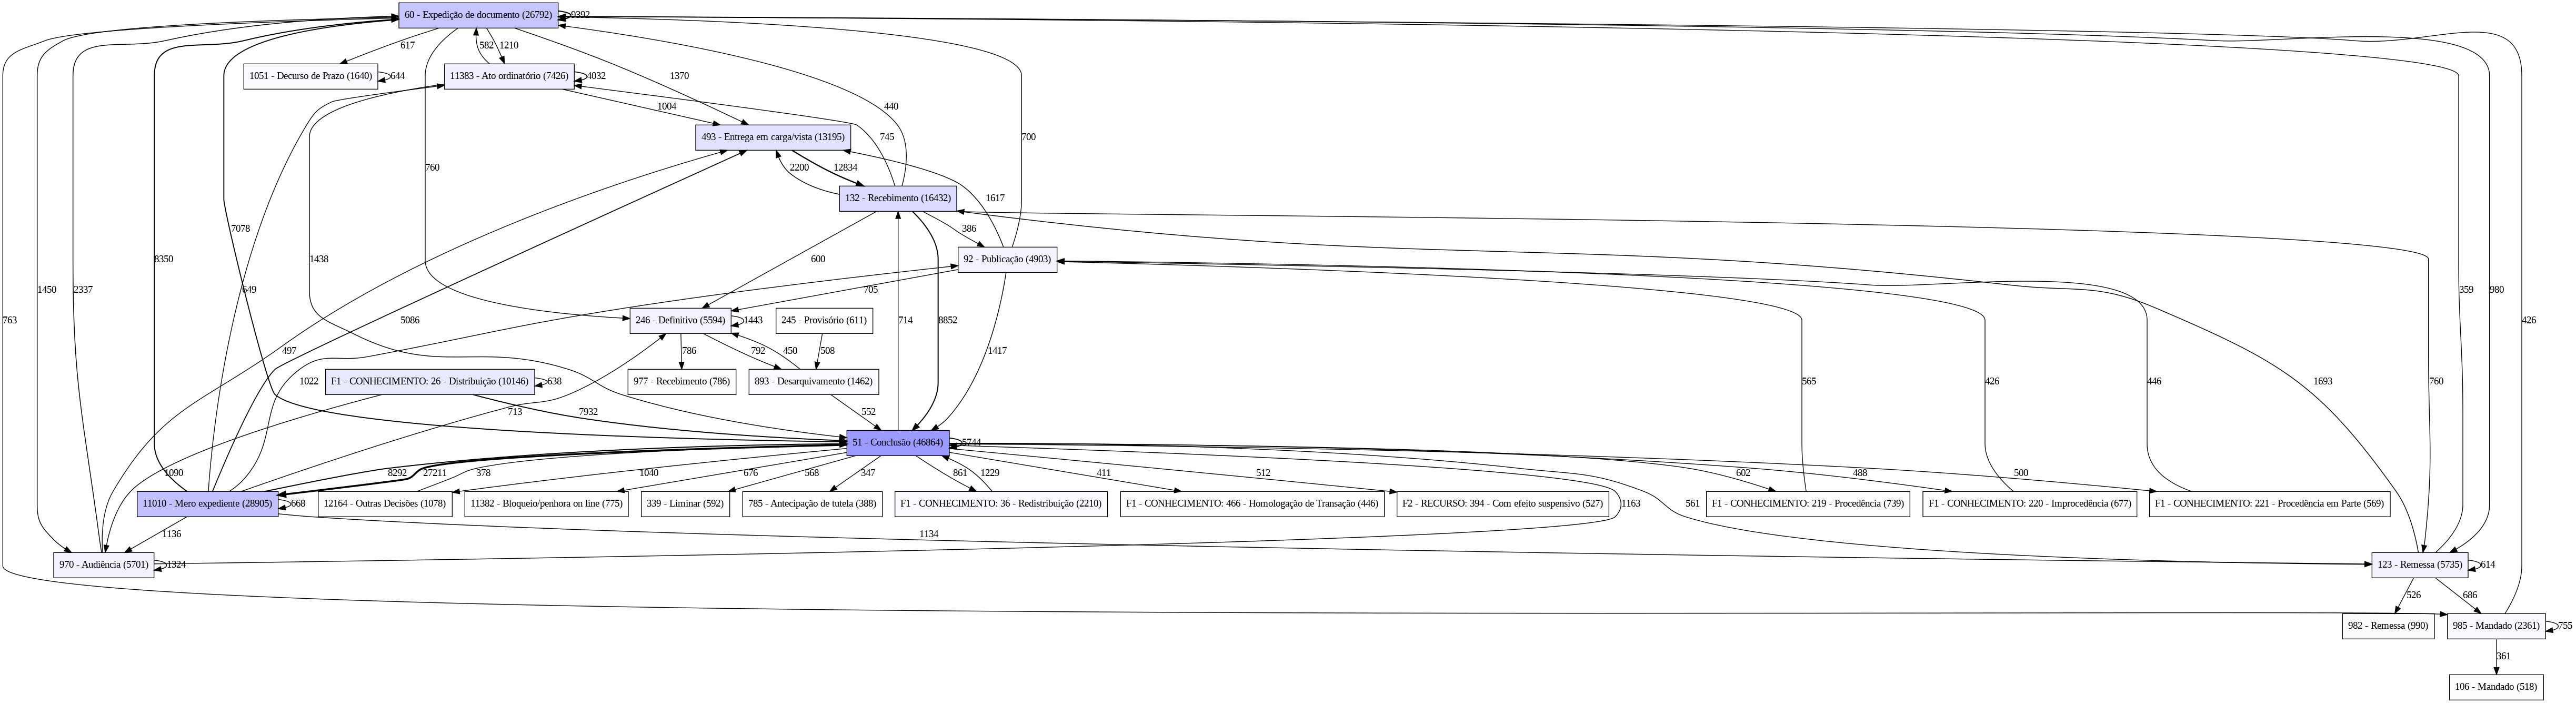

In [16]:
eventLog = gerar_log_eventos('Estadual', 'TJPE', 'Cível', None, None, None, None, None, None, None, '65')
if eventLog != None :
    dfg = gerar_dfg_model_from_log_eventos(eventLog)
    gviz = gerar_view_dfg_model(eventLog, dfg, metric_type = 'FREQUENCY')
    dfg_visualization.view(gviz)

In [17]:
# Gera as estatisticas do modelo
def gerar_estatisticas_model_from_log_eventos(eventLog):

    parameters_stats = {
        case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
    }
    
    # (quantidade de casos no event log)
    all_case_durations = case_statistics.get_all_casedurations(eventLog, parameters=parameters_stats)
    # (duração do caso mais rápido)
    min_case_duration = min(all_case_durations)
    # (duração do caso mais demorado)
    max_case_duration = max(all_case_durations)
    # (média de duração dos casos)
    median_case_duration = case_statistics.get_median_caseduration(eventLog, parameters=parameters_stats)
    
    parameters_arrival = {
        case_arrival.Parameters.TIMESTAMP_KEY: "time:timestamp"
    }

    # (distância média entre a chegada de dois casos consecutivos)
    case_arrival_ratio = case_arrival.get_case_arrival_avg(eventLog, parameters=parameters_arrival)
    # (distância média entre a finalização de dois casos consecutivos)
    case_dispersion_ratio = case_arrival.get_case_dispersion_avg(eventLog, parameters=parameters_arrival)
    
    return ModeloEstatisticas(qtde_casos=len(all_case_durations), caso_dur_min=min_case_duration, caso_dur_max=max_case_duration, \
        caso_dur_media=median_case_duration, taxa_chegada_casos=case_arrival_ratio, taxa_dispersao_casos=case_dispersion_ratio)


In [19]:
# Gera as estatisticas do modelo com base nos parametros
def gerar_estatistica_model_from_params(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, 
                                     dtinicio, dtfim, baixado = None, sensibility = '60'):
    
    est_model = None
    
    eventLog = gerar_log_eventos(ramo_justica, codtribunal, atuacao, grau, codorgaoj, codnatureza, codclasse, dtinicio, dtfim, baixado, sensibility)
    
    if eventLog is not None :
        est_model = gerar_estatisticas_model_from_log_eventos(eventLog)
    
    return est_model

In [20]:
estat = gerar_estatistica_model_from_params('Estadual', 'TJPE', 'Cível', None, None, None, None, None, None, None, '65')
print(estat.qtde_casos)

9497


In [16]:
dfg_perf = dfg_discovery.apply(eventLog, variant=dfg_discovery.Variants.PERFORMANCE)
from pm4py.statistics.start_activities.log import get as start_activities
from pm4py.statistics.end_activities.log import get as end_activities
sa = start_activities.get_start_activities(eventLog)
ea = end_activities.get_end_activities(eventLog)

In [17]:
from pm4py.statistics.traces.log import case_arrival
ratio = case_arrival.get_case_arrival_avg(eventLog)
print(ratio)

4602.0


In [18]:
from pm4py.objects.conversion.dfg import converter
net, im, fm = converter.apply(dfg_perf, variant=converter.Variants.VERSION_TO_PETRI_NET_ACTIVITY_DEFINES_PLACE,
                              parameters={converter.Variants.VERSION_TO_PETRI_NET_ACTIVITY_DEFINES_PLACE.value.Parameters.START_ACTIVITIES: sa,
                                          converter.Variants.VERSION_TO_PETRI_NET_ACTIVITY_DEFINES_PLACE.value.Parameters.END_ACTIVITIES: ea})

In [21]:
from pm4py.simulation.montecarlo import simulator as montecarlo_simulation
from pm4py.algo.conformance.tokenreplay.algorithm import Variants
parameters = {}
parameters[
    montecarlo_simulation.Variants.PETRI_SEMAPH_FIFO.value.Parameters.TOKEN_REPLAY_VARIANT] = Variants.BACKWARDS
parameters[montecarlo_simulation.Variants.PETRI_SEMAPH_FIFO.value.Parameters.PARAM_CASE_ARRIVAL_RATIO] = 4602
simulated_log, res = montecarlo_simulation.apply(eventLog, net, im, fm, parameters=parameters)

INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539637.920957 started the replay operation.
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539638.1254394 ended the replay operation.
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539641.4609692 terminated successfully thread ID 0
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.1218567 diagnostics for thread 1: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessão: 0, F2 - RECURSO: 239 - Não-Provimento: 0, 132 - Recebimento: 0, source: 0, 417 - Inclusão em pauta: 0, F1 - CONHECIMENTO: 220 - Improcedência: 0, F1 - CONHECIMENTO: 26 - Distribuição: 0, 51 - Conclusão: 0}
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.1244724 diagnostics for thread 4: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessão: 0, F2 - RECURSO: 239 - Não-Provimento: 0, 132 - Recebimento: 0, source: 

INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.2987454 diagnostics for thread 22: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessão: 0, F2 - RECURSO: 239 - Não-Provimento: 0, 132 - Recebimento: 0, source: 0, 417 - Inclusão em pauta: 0, F1 - CONHECIMENTO: 220 - Improcedência: 0, F1 - CONHECIMENTO: 26 - Distribuição: 0, 51 - Conclusão: 0}
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.302178 diagnostics for thread 21: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessão: 0, F2 - RECURSO: 239 - Não-Provimento: 0, 132 - Recebimento: 0, source: 0, 417 - Inclusão em pauta: 0, F1 - CONHECIMENTO: 220 - Improcedência: 0, F1 - CONHECIMENTO: 26 - Distribuição: 0, 51 - Conclusão: 0}
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.3055177 diagnostics for thread 23: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessão

INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.4750109 diagnostics for thread 41: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessão: 0, F2 - RECURSO: 239 - Não-Provimento: 0, 132 - Recebimento: 0, source: 0, 417 - Inclusão em pauta: 0, F1 - CONHECIMENTO: 220 - Improcedência: 0, F1 - CONHECIMENTO: 26 - Distribuição: 0, 51 - Conclusão: 0}
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.4954927 diagnostics for thread 43: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessão: 0, F2 - RECURSO: 239 - Não-Provimento: 0, 132 - Recebimento: 0, source: 0, 417 - Inclusão em pauta: 0, F1 - CONHECIMENTO: 220 - Improcedência: 0, F1 - CONHECIMENTO: 26 - Distribuição: 0, 51 - Conclusão: 0}
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.5005689 diagnostics for thread 45: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessã

INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.6614876 diagnostics for thread 65: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessão: 0, F2 - RECURSO: 239 - Não-Provimento: 0, 132 - Recebimento: 0, source: 0, 417 - Inclusão em pauta: 0, F1 - CONHECIMENTO: 220 - Improcedência: 0, F1 - CONHECIMENTO: 26 - Distribuição: 0, 51 - Conclusão: 0}
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.6639018 diagnostics for thread 64: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessão: 0, F2 - RECURSO: 239 - Não-Provimento: 0, 132 - Recebimento: 0, source: 0, 417 - Inclusão em pauta: 0, F1 - CONHECIMENTO: 220 - Improcedência: 0, F1 - CONHECIMENTO: 26 - Distribuição: 0, 51 - Conclusão: 0}
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.666496 diagnostics for thread 63: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessão

INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.8430846 diagnostics for thread 84: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessão: 0, F2 - RECURSO: 239 - Não-Provimento: 0, 132 - Recebimento: 0, source: 0, 417 - Inclusão em pauta: 0, F1 - CONHECIMENTO: 220 - Improcedência: 0, F1 - CONHECIMENTO: 26 - Distribuição: 0, 51 - Conclusão: 0}
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.8536804 diagnostics for thread 85: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessão: 0, F2 - RECURSO: 239 - Não-Provimento: 0, 132 - Recebimento: 0, source: 0, 417 - Inclusão em pauta: 0, F1 - CONHECIMENTO: 220 - Improcedência: 0, F1 - CONHECIMENTO: 26 - Distribuição: 0, 51 - Conclusão: 0}
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539670.8574479 diagnostics for thread 86: blocked places by semaphore: {60 - Expedição de documento: 0, 873 - Deliberação em Sessã

INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539698.553888 terminated for timeout thread ID 15
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539698.5563793 terminated for timeout thread ID 14
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539698.5615015 terminated for timeout thread ID 50
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539698.5770526 terminated for timeout thread ID 52
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539698.585337 terminated for timeout thread ID 53
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539698.5962863 terminated for timeout thread ID 54
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539698.6097245 terminated for timeout thread ID 5
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539698.641269 terminated for timeout thread ID 59
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539698.6439269 termi

INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539699.7996686 terminated for timeout thread ID 95
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539699.8264177 terminated for timeout thread ID 99
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539699.8614354 terminated for timeout thread ID 17
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539699.8666902 terminated for timeout thread ID 16
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539699.8759534 terminated for timeout thread ID 76
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539699.8775523 terminated for timeout thread ID 86
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539699.939273 terminated for timeout thread ID 78
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539699.9701123 terminated for timeout thread ID 8
INFO:pm4py.simulation.montecarlo.variants.petri_semaph_fifo:1605539700.3280058 ter

In [30]:
import random
last_timestamp = max(event["time:timestamp"] for trace in eventLog for event in trace).timestamp()
first_timestamp = min(event["time:timestamp"] for trace in eventLog for event in trace).timestamp()
pick_trans = random.choice(list(res["transitions_interval_trees"]))
print(pick_trans)
n_div = 10
i = 0
while i < n_div:
    timestamp = first_timestamp + (last_timestamp - first_timestamp)/n_div * i
    print("\t", timestamp, len(res["transitions_interval_trees"][pick_trans][timestamp]))
    i = i + 1

417 - Inclusão em pauta_13
	 1584525989.0 0
	 1585243875.1 0
	 1585961761.2 0
	 1586679647.3 0
	 1587397533.4 0
	 1588115419.5 0
	 1588833305.6 0
	 1589551191.7 0
	 1590269077.8 0
	 1590986963.9 0


In [42]:
from pm4py.algo.filtering.log.variants import variants_filter
log = variants_filter.apply_auto_filter(eventLog)

In [49]:
from pm4py.objects.stochastic_petri import ctmc
reach_graph, tang_reach_graph, stochastic_map, q_matrix = ctmc.get_tangible_reachability_and_q_matrix_from_dfg_performance(dfg_perf, parameters={"start_activities": sa, "end_activities": ea})
print(tang_reach_graph.states)

{F0NÃOCLASSIFICADOTrânsitoemjulgado1, source1, sink1, F2RECURSOProvimento1, F0NÃOCLASSIFICADOBaixaDefinitiva1, F1CONHECIMENTODistribuição1}


In [73]:
# pick the source state
state = [x for x in tang_reach_graph.states if x.name == "F2RECURSOProvimento1"][0]

# analyse the distribution over the states of the system starting from the source after 172800.0 seconds (2 days)
transient_result = ctmc.transient_analysis_from_tangible_q_matrix_and_single_state(
    tang_reach_graph, q_matrix, state, 86400.0)
print(transient_result)

Counter({F2RECURSOProvimento1: 0.9894529915741901, F0NÃOCLASSIFICADOTrânsitoemjulgado1: 0.010544290457709472, sink1: 2.7179680375996663e-06, F0NÃOCLASSIFICADOBaixaDefinitiva1: 6.279953578547772e-14, source1: 8.640398952046265e-23, F1CONHECIMENTODistribuição1: 1.834116684260402e-23})


In [74]:
state = [x for x in tang_reach_graph.states if x.name == "F0NÃOCLASSIFICADOTrânsitoemjulgado1"][0]
transient_result = ctmc.transient_analysis_from_tangible_q_matrix_and_single_state(
    tang_reach_graph, q_matrix, state, 864000.0)
print(transient_result)

Counter({F0NÃOCLASSIFICADOTrânsitoemjulgado1: 0.9948674179473852, sink1: 0.005132582046689538, F0NÃOCLASSIFICADOBaixaDefinitiva1: 5.925217347269376e-12, F2RECURSOProvimento1: -3.670137984985936e-22, F1CONHECIMENTODistribuição1: -1.48826350574468e-20, source1: -1.1094696350024533e-19})


In [32]:
#statistics 
from pm4py.statistics.traces.log import case_statistics
all_case_durations = case_statistics.get_all_casedurations(eventLog, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"})
min_case_duration = min(all_case_durations)
max_case_duration = max(all_case_durations)

# (quantidade de casos no event log)
print("num_cases: " + str(len(all_case_durations)))
# (duração do caso mais rápido)
print("min_case_duration: " + str(min_case_duration))
# (duração do caso mais demorado)
print("max_case_duration: " + str(max_case_duration))

from pm4py.statistics.traces.log import case_statistics
median_case_duration = case_statistics.get_median_caseduration(eventLog, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
})
# (média de duração dos casos)
print("median_case_duration: " + str(median_case_duration))

# razão de chegada de casos
from pm4py.statistics.traces.log import case_arrival
case_arrival_ratio = case_arrival.get_case_arrival_avg(eventLog, parameters={
    case_arrival.Parameters.TIMESTAMP_KEY: "time:timestamp"})
# (distância média entre a chegada de dois casos consecutivos)
print("case_arrival_ratio: " + str(case_arrival_ratio))

case_dispersion_ratio = case_arrival.get_case_dispersion_avg(eventLog, parameters={
    case_arrival.Parameters.TIMESTAMP_KEY: "time:timestamp"})
# (distância média entre a finalização de dois casos consecutivos)
print("case_dispersion_ratio: " + str(case_dispersion_ratio))

num_cases: 44
min_case_duration: 3635898.0
max_case_duration: 7174175.0
median_case_duration: 6255556.0
case_arrival_ratio: 4602.0
case_dispersion_ratio: 3153.0


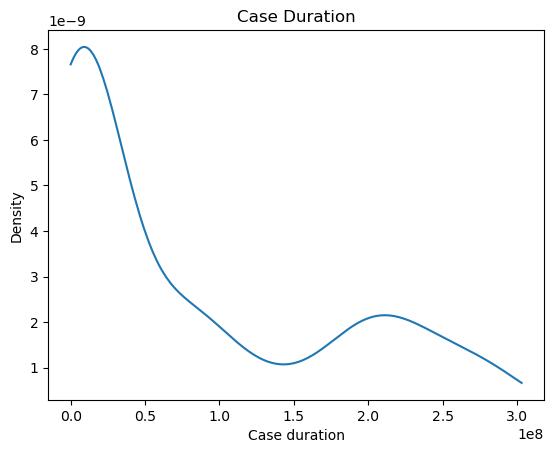

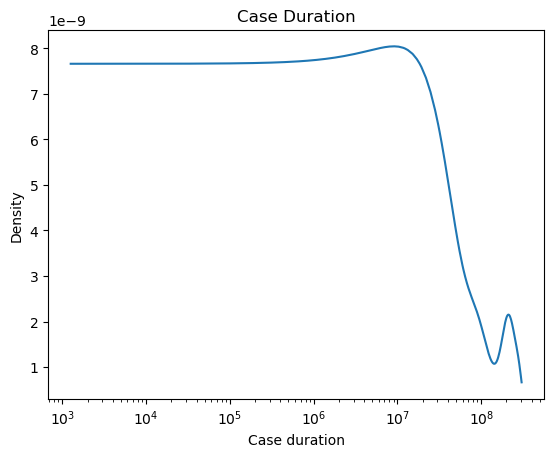

In [101]:
from pm4py.util import constants
from pm4py.statistics.traces.log import case_statistics
x, y = case_statistics.get_kde_caseduration(eventLog, parameters={constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: "time:timestamp"})

from pm4py.visualization.graphs import visualizer as graphs_visualizer

gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.CASES)
graphs_visualizer.view(gviz)

gviz = graphs_visualizer.apply_semilogx(x, y, variant=graphs_visualizer.Variants.CASES)
graphs_visualizer.view(gviz)

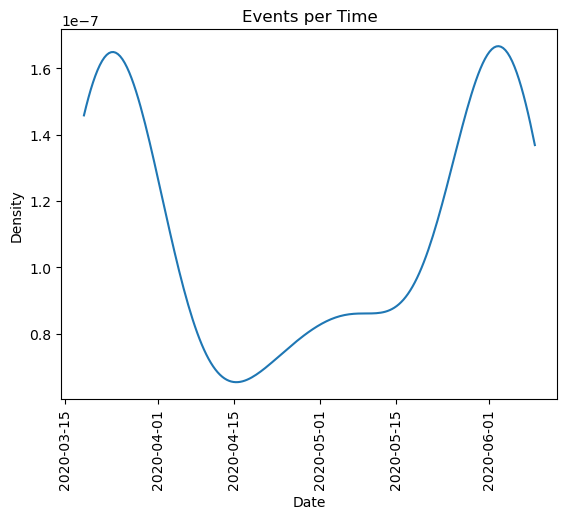

In [33]:
from pm4py.algo.filtering.log.attributes import attributes_filter

x, y = attributes_filter.get_kde_date_attribute(eventLog, attribute="time:timestamp")

from pm4py.visualization.graphs import visualizer as graphs_visualizer

gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.DATES)
graphs_visualizer.view(gviz)